In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sy
import scipy.stats
import pandas as pd
import PIL.Image
import os
import string

from functions.matrix_analysis import Select_entangled_fraction
from functions.matrix_analysis import length_L_pattern
from functions.plotting_tools import set_layout
from functions.plotting_tools import save_figures
from functions.matrix_analysis import open_matrix
from functions.matrix_analysis import PlotMatrix_SelectFraction

## MATRIX ANALYSIS: L-PATTERN LENGTH

In this notebook we analyze topology matrices:
- We measure the length of the L-patterns and plot them as 'topology matrix traces'
- We subdivide the L patterns into 'small' and 'big' (below and above the median) by quantile analysis. We plot the result as bar plots.

Load all topology matrix files (in tif format) from a cell

In [3]:
path ='results/matrices/cell8'
path_figures='results/figures'
cell=path[-5:]

files = os.listdir(path)
files_tif = [f for f in files if f[-3:] == 'tif']
n_all_chr=len(files_tif)

letters=list(string.ascii_lowercase)
chr_vec=['chr {}'.format(letter) for letter in letters[:n_all_chr]]

set_layout()

print('Analyzing cell {}'.format(cell[-1:]))

Analyzing cell 8


Plot only parallel/cross in the topology matrix

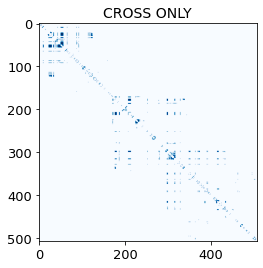

In [7]:
select_relation='Cross'
mat=open_matrix('{}/{}'.format(path,files_tif[0]))
PlotMatrix_SelectFraction(select_relation, mat)

Create dataframe with length L patterns

In [8]:
df_Lpatterns=pd.DataFrame()

n_chr=len(files_tif)
for t in range(n_chr):
    mat=open_matrix('{}/{}'.format(path,files_tif[t]))
    mat_entangled = Select_entangled_fraction(mat)
    length=length_L_pattern(mat_entangled)
    df_Lpatterns['{}'.format(chr_vec[t])]=pd.Series(length)
    
df_Lpatterns['cell']=cell
df_Lpatterns.to_csv('results/L pattern size/Lpatterns_{}.csv'.format(cell))


## COMPARE L PATTERNS IN DIFFERENT CELLS

Load L patterns sizes for all cells

In [9]:
path= 'results/L pattern size'
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
cells_highclustering=['cell1', 'cell4', 'cell6', 'cell8']
cells_lowclustering=['cell2', 'cell3', 'cell5', 'cell7']

df_Lpatterns_allcells=pd.DataFrame()

for file in files_csv:
    cell=file[-9:-4]
    df = pd.read_csv('{}/{}'.format(path, file))
    
    if cell in cells_highclustering:
        df['Clustering'] = 'High clustering'
    else:
        df['Clustering'] = 'Low clustering'
    
    frames= [df_Lpatterns_allcells, df]
    df_Lpatterns_allcells=pd.concat(frames)

cells=np.unique(df_Lpatterns_allcells['cell'])
df_Lpatterns_allcells.to_csv('results/L pattern size/all cells/Lpatterns_allcells.csv')

Plot comparison of L loop length for one chromosome, all cells

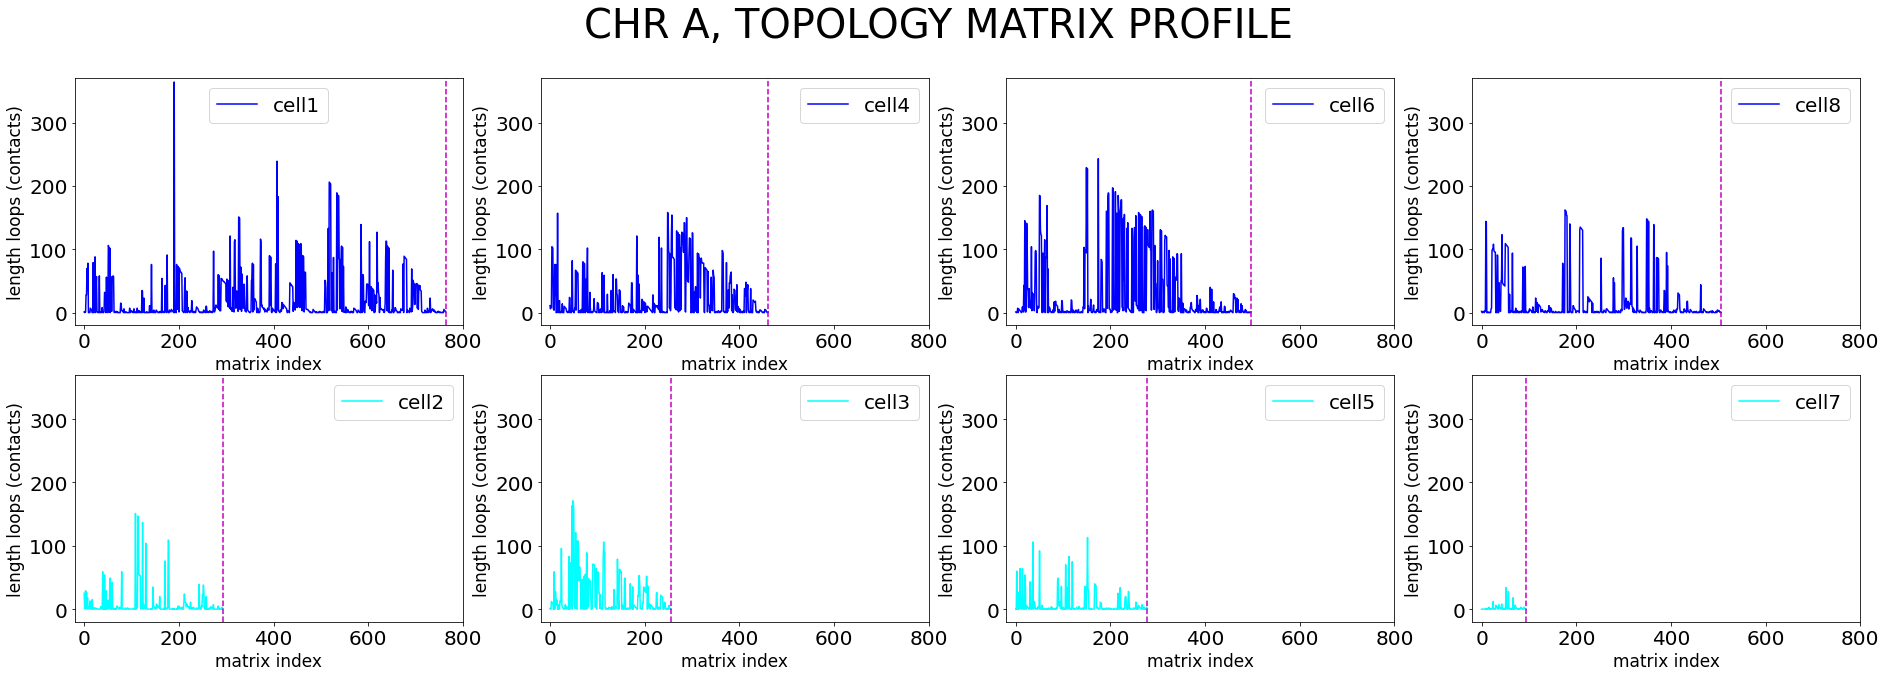

In [10]:
#ordering cells high clustering first, then low clustering
cells_reordered=cells_highclustering + cells_lowclustering
chosen_chr=chr_vec[0]
set_layout(20,17,30)
fig, axs = plt.subplots(2, 4, figsize= (32,10))
colors = ['blue', 'cyan']

for i in range(2):
    for j in range(4):
        
        t = np.ravel_multi_index((i,j), (2,4))
        
        y_plot= df_Lpatterns_allcells[chosen_chr][df_Lpatterns_allcells['cell']==cells_reordered[t]]
        index=np.linspace(0, len(y_plot),len(y_plot))
        sns.lineplot(x=index, y= y_plot, label=cells_reordered[t], color=colors[i], ax = axs[i,j])
        
        xlim=np.max(index)
        axs[i,j].axvline(xlim, 0, 1.5, color='m', ls= '--')
        
        axs[i,j].set_xlim(-20,800)
        axs[i,j].set_ylim(-20,370)
        axs[i,j].set_ylabel('length loops (contacts)')
        axs[i,j].set_xlabel('matrix index')
    
plt.suptitle('{}, TOPOLOGY MATRIX PROFILE'.format(chosen_chr.upper()), fontsize=40);

#save_figures(fig,path, name_file = 'comparison_lpatterns_{}'.format(chosen_chr))

## QUANTILE ANALYSIS

Load data L patterns for all cells, create L loops dataframe

In [11]:
df_Lpatterns_allcells=pd.read_csv('results/L pattern size/all cells/Lpatterns_allcells.csv')
cells= np.unique(df_Lpatterns_allcells['cell'])
n_all_chr=20
letters=list(string.ascii_lowercase)
chr_vec=['chr {}'.format(letter) for letter in letters[:n_all_chr]]

length_Lloops=[]
cells_Lloops=[]
clustering_Lloops=[]
chrom_Lloops=[]

for chrom in chr_vec:
    for x in range(len(df_Lpatterns_allcells[chrom])):
        length_Lloops.append(df_Lpatterns_allcells[chrom][x])
        cells_Lloops.append(df_Lpatterns_allcells['cell'][x])
        clustering_Lloops.append(df_Lpatterns_allcells['Clustering'][x])
        chrom_Lloops.append(chrom)
    
df_Lloops={'length patterns':length_Lloops, 'Cell':cells_Lloops,
           'Clustering':clustering_Lloops, 'Chromosome':chrom_Lloops}
df_Lloops=pd.DataFrame(df_Lloops)
Lloops_sortbycells = df_Lloops.sort_values('Cell', ascending=True)

nan_value = float("NaN")
Lloops_sortbycells.replace("", nan_value, inplace=True)
Lloops_sortbycells.dropna(subset = ["length patterns"],inplace=True)
Lloops_sortbycells=Lloops_sortbycells[Lloops_sortbycells['length patterns']!=0]

Lloops_sortbycells.to_csv('results/L pattern size/all cells/Lloops.csv')

Divide loops in 'big' and 'small' (above and below the median) 

In [12]:
quantiles=[]
cell_vector=np.unique(Lloops_sortbycells['Cell'])
for t in range(len(cell_vector)):
    df_cell1=Lloops_sortbycells[Lloops_sortbycells['Cell']==cell_vector[t]]
    col=pd.qcut(df_cell1['length patterns'],2, labels=[ "small","big"])  
    col=np.array(col)
    for x in range(len(col)):
        quantiles.append(col[x])

Lloops_sortbycells['Quantiles']=quantiles
df_Loops_small=Lloops_sortbycells[Lloops_sortbycells['Quantiles']=='small']
df_Loops_big=Lloops_sortbycells[Lloops_sortbycells['Quantiles']=='big']

Plot barplots for L loop size, for small or big loops

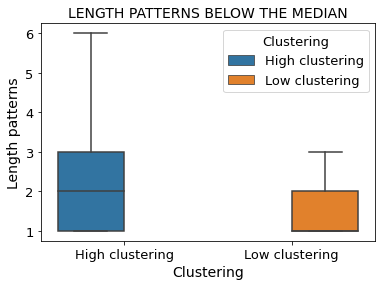

In [14]:
set_layout()
selection = 'below'
name_fig = 'length patterns {} the median'.format(selection)

if selection == 'above':
    df_sel = df_Loops_big
else:
    df_sel = df_Loops_small

plot=plt.figure()
plt.title(name_fig.upper())
sns.boxplot(x='Clustering', y='length patterns', hue='Clustering', data=df_sel, showfliers = False)
plt.ylabel('Length patterns');

#save_figures(plot,path, name_file = name_fig, method= selection)